<a href="https://colab.research.google.com/github/TimTieng/TEADS-Generative-AI-Video-Classification/blob/main/TimTieng_Project3_Updated_AOF_(7).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Technology Excellence - Advanced Data Science (TEADS) - Generative AI Video Classification Project

#####  **Project Authors:** Tim Tieng and Afia Owusu-Forfie

##### **Dates:** April 22, 2024 to April 26, 2024

##### **Team Name:** Team 5 - AI Now

##### **Project Module:** Data Collection and Preparation

**Objective**: Develop a model to classify video content into categories such as sports, news, movies, etc., and enhance this classification by generating descriptive captions or summaries that provide additional context about the content. This can be particularly useful for content curation platforms, accessibility applications (e.g., providing descriptions for the hearing impaired), or educational tools where supplementary information enhances learning.

**Data**: Public Dataset: Use a dataset like the YouTube-8M, which has a vast collection of labeled video data suitable for training video classification models.

In [1]:
!pip install chardet

In [2]:
!pip install feature_engine

In [3]:
#!pip install -r requirements.txt --use-deprecated=legacy-resolver

In [4]:
# Import Packages for project

# Standard Libraries
import numpy as np
import os
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Algorithms, Modeling and Data Pre-processing

import feature_engine
from feature_engine.encoding import OrdinalEncoder
from feature_engine.transformation import YeoJohnsonTransformer
from scipy.stats import anderson, chi2_contingency
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score,precision_score, roc_auc_score,recall_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Deep Learning
import keras
from keras import layers
from keras.layers import RandomFlip, RandomRotation, Rescaling, BatchNormalization, Conv2D, MaxPooling2D, Dense, Input
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Model Optimization and Hyperparameter Tuning
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, tpe, hp
#import mlflow

import tensorboard

In [12]:
# unzipping the files in the frame-sample zip folder
!unzip "/content/frame-sample.zip" -d '/content/frame-sample'

Archive:  /content/frame-sample.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/frame-sample.zip or
        /content/frame-sample.zip.zip, and cannot find /content/frame-sample.zip.ZIP, period.


For some reason the same !unzip command does not work for frame-sample.zip eventhough it works for validate-sample.zip

In [13]:
# unzipping the files in the validate-sample zip folder
!unzip '/content/validate-sample.zip' -d '/content/validate-sample'

Archive:  /content/validate-sample.zip
replace /content/validate-sample/validate/validate01.tfrecord? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
# Obtain the data - Due to issues with larger dataset, the project group is using the dataset provided via kaggle competition that used youtube-8M data

frame_level_record1 = "/content/frame-sample/frame/train00.tfrecord"
frame_level_record2 = "/content/frame-sample/frame/train01.tfrecord"
validation_level_record1 = "/content/validate-sample/validate/validate00.tfrecord"
validation_level_record2 = "/content/validate-sample/validate/validate01.tfrecord"
print(f"Frame Directory Data Present: {os.listdir('/content/frame-sample/frame')}")
print(f"Validation Directory Data Present: {os.listdir('/content/validate-sample/validate')}")


Frame Directory Data Present: ['train00.tfrecord', 'train01.tfrecord']
Validation Directory Data Present: ['validate00.tfrecord', 'validate01.tfrecord']


This confirms that we have frame-level data and validation data loaded into our project directory.

Extract Video-Level Information from the frame-level files: train00.tfrecord

### Tim Test/Experimental code begins here

In [ ]:
def parse_tfrecord(example_proto):
    """
    Parses a single example from a TFRecord file into a tensor suitable for training or evaluation.

    This function defines and uses a fixed schema to parse each example in the TFRecord file. The schema is defined using
    TensorFlow's parsing functions which map the data from a serialized `tf.train.Example` protobuf to tensors. The keys
    in the `feature_description` dictionary specify the expected features in the TFRecord, and their corresponding values
    define the type and shape of the data.

    Parameters:
    example_proto (tf.Tensor): A tensor containing a serialized `tf.train.Example` protobuf.

    Returns:
    dict: A dictionary where each key corresponds to a feature specified in the TFRecord schema. Each value is a
    TensorFlow tensor. The keys and their respective tensors are:
        - 'id': A tensor containing the unique identifier of the video. This is a scalar string tensor.
        - 'labels': A sparse tensor containing a list of integer labels associated with the video.
        - 'rgb': A dense tensor of shape [1024] containing the RGB features of the video frame.
        - 'audio': A dense tensor of shape [128] containing the audio features of the video frame.
        - 'segment_start_times': (Optional) A sparse tensor containing start times for each labeled segment.
        - 'segment_end_times': (Optional) A sparse tensor containing end times for each labeled segment.
        - 'segment_labels': (Optional) A sparse tensor containing labels for each segment.
        - 'segment_scores': (Optional) A sparse tensor containing binary scores indicating positive or negative sentiment for each segment label.

    The optional keys ('segment_start_times', 'segment_end_times', 'segment_labels', 'segment_scores') should be uncommented
    in the feature description if segment-level data is being processed.

    Example:
    To use this function, ensure it is mapped over a dataset created from a TFRecord file, like so:
    dataset = tf.data.TFRecordDataset("path_to_tfrecord_file.tfrecord")
    parsed_dataset = dataset.map(parse_tfrecord)
    """

    # Define your feature description
    feature_description = {
        'id': tf.io.FixedLenFeature([], tf.string),
        'labels': tf.io.VarLenFeature(tf.int64),
        'rgb': tf.io.FixedLenFeature([1024], tf.float32, default_value=np.zeros([1024], dtype=np.float32)),
        'audio': tf.io.FixedLenFeature([128], tf.float32, default_value=np.zeros([128], dtype=np.float32)),
        # Uncomment these if you're handling segment data
        'segment_start_times': tf.io.VarLenFeature(tf.int64),
        'segment_end_times': tf.io.VarLenFeature(tf.int64),
        'segment_labels': tf.io.VarLenFeature(tf.int64),
        'segment_scores': tf.io.VarLenFeature(tf.float32),
    }
    return tf.io.parse_single_example(example_proto, feature_description)

In [ ]:
def load_dataset(file_path):
    """
    Purpose: To take load tfrecord files for future manipulation
    Arguments: a filepath or variable that stores a filepath to a tfrecord file
    """
    raw_dataset = tf.data.TFRecordDataset(file_path)
    parsed_dataset = raw_dataset.map(parse_tfrecord) # map the data
    return parsed_dataset

In [ ]:
# Create a dataset object using the load_dataset() which calls in parse_tfrecord()
dataset = load_dataset(frame_level_record1)

In [ ]:
#View and inspect parsed dataset of train00.tfrecord
dataset.element_spec

descriptive stats on segments

pd dataframe - only import

Figure out how to access data of a tensorflow mapdata object

In [ ]:
type(dataset)

In [ ]:
# Since there are over observations, printing only the first 20
for index, item in enumerate(dataset.as_numpy_iterator()):
    if index < 10:
        print(item)
    else:
        break

### Observations

We can see a each record can have numerous label values. The values in the label list of each item can be mapped to the values in the vocabulary data dictionary.

**Audio** - this is an empty list that was pre-populated with np.zeroes during the collection phase

**RGB** - like audio, this is an array or np.zeros

**Segment_X** thes are all empty arrays. these features are labeled as optional as per youtube-8m documenation


In [ ]:
#added by Afia
!pip install pandas
import pandas as pd


This code did NOT work in the Colab environment for Afia eventhough it worked for Tim

In [ ]:
# # Read in the vocabulary csv file
# vocab_path = "/content/vocabulary.csv"
# vocab= pd.read_csv(vocab_path)
# vocab_df = pd.DataFrame(vocab)

# vocab_df

In [ ]:
# unique_labels = vocab_df['Name'].unique()
# unique_labels

In [ ]:
# unique_label_count = vocab_df['Name'].nunique()
# print(f"Unique Video Labels: {unique_label_count}")

## Tim Test/Experimental code ends here

In [16]:
## Experimenting with information from Kaggle User: Kranti Kumar
# https://www.kaggle.com/code/jagannathrk/analysis-youtube8m-2019

In [15]:
frame_lvl_record = "/content/frame-sample/frame/train00.tfrecord"

In [17]:
print(os.listdir("/content/frame-sample/frame"))
print(os.listdir("/content/validate-sample/validate"))

['train00.tfrecord', 'train01.tfrecord']
['validate00.tfrecord', 'validate01.tfrecord']


In [18]:
!pip install pandas

In [19]:
import pandas as pd

In [20]:
sub = pd.read_csv('/content/sample_submission.csv')
sub.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Class     1000 non-null   int64 
 1   Segments  1000 non-null   object
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


In [21]:
# sub.head() #did NOT work

Exploring Data (TFRecord format) using a subsample of the YouTube-8M video & frame-level data.

In [22]:
# from tensorflow import python_io #python_io broke the code. do NOT use

In [23]:
!pip show tensorflow #added by Afia

Name: tensorflow
Version: 2.15.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine-rl, tf_keras


1st attempt did NOT work. Threw this error: AttributeError: module 'tensorflow' has no attribute 'python_io'


In [ ]:
# vid_ids = []
# labels = []

# for example in tf.python_io.tf_record_iterator(frame_lvl_record):
#     tf_example = tf.train.Example.FromString(example)
#     vid_ids.append(tf_example.features.feature['id']
#                    .bytes_list.value[0].decode(encoding='UTF-8'))
#     labels.append(tf_example.features.feature['labels'].int64_list.value)

2nd attempt also did NOT work. Threw this error: AttributeError: module 'tensorflow._api.v2.io' has no attribute 'tf_record_iterator'


In [ ]:
# import tensorflow as tf

# vid_ids = []
# labels = []

# for example in tf.io.tf_record_iterator(frame_lvl_record):
#     tf_example = tf.train.Example.FromString(example)
#     vid_ids.append(tf_example.features.feature['id']
#                    .bytes_list.value[0].decode(encoding='UTF-8'))
#     labels.append(tf_example.features.feature['labels'].int64_list.value)

Using the suggested code by Colab, the third attempt worked!

In [27]:
!pip install tensorflow==2.8

import tensorflow as tf

vid_ids = []
labels = []

for example in tf.compat.v1.io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 822.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.5/462.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  Attempting uninstall: google-auth-oauthlib
    Found existing ins

The third attempt was re-run without the pip and import lines above

In [28]:

vid_ids = []
labels = []

for example in tf.compat.v1.io.tf_record_iterator(frame_lvl_record):
    tf_example = tf.train.Example.FromString(example)
    vid_ids.append(tf_example.features.feature['id']
                   .bytes_list.value[0].decode(encoding='UTF-8'))
    labels.append(tf_example.features.feature['labels'].int64_list.value)

In [29]:
print('Number of videos in this tfrecord: ',len(vid_ids))
print ('Number of labels in this tfrecord: ', len (labels))
print('Picking a youtube video id:',vid_ids[15])

Number of videos in this tfrecord:  1015
Number of labels in this tfrecord:  1015
Picking a youtube video id: FF00


As described on the YouTube8M download page, for privacy reasons, the video id has been randomly generated and does not directly correspond to the actual YouTube video id. To convert the id into the actual YouTube video id, we follow link: http://data.yt8m.org/2/j/i/UL/UL00.js
For more information, go here: https://www.kaggle.com/code/inversion/starter-kernel-yt8m-2019-sample-data

In [30]:

from IPython.display import YouTubeVideo #without this line, YouTubeVideo will NOT work

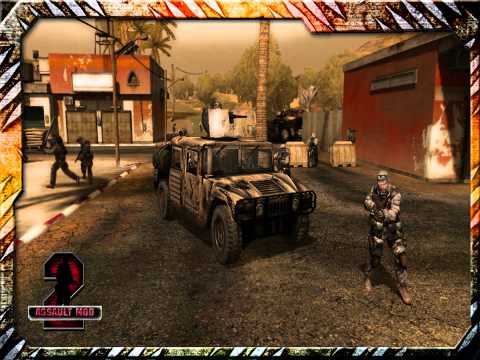

In [31]:
# With that video id, we can play the video
YouTubeVideo('UzXQaOLQVCU')
# You can view directly on YouTube at: https://www.youtube.com/watch?v=UzXQaOLQVCU

In [32]:
print(vid_ids)

['op00', 'O900', 'Oq00', 'Li00', '1300', 'gG00', 'xI00', 'i900', 'R100', 'sg00', '0900', 'gk00', 'VK00', 'UL00', 'R900', 'FF00', 'Jw00', 'nm00', 't600', '1J00', 'LT00', '4i00', 'L700', 'QA00', 'Ra00', 'rC00', 'pf00', '8h00', 'J400', 'fd00', 'Ut00', '0H00', 'dH00', 'Rc00', 'ie00', 'Ly00', 'mQ00', 'mY00', 'Q000', 'Mw00', 'Jh00', 'VQ00', 'rl00', 'T700', 'w200', 'Hs00', 'Zc00', 'sv00', 'X200', '0E00', 'am00', '9p00', 'ml00', 'Px00', 'IB00', '7300', '8r00', 'FD00', 'jj00', 'Us00', 'f600', 'wM00', 'a900', 'Nc00', 'mZ00', '4S00', 'MD00', 'b400', 'Wo00', 'oE00', 'ze00', 'lC00', 'NG00', 'Ea00', 'Xs00', 'ot00', '1c00', 'CV00', 'rh00', 'zw00', 'NA00', 'ln00', 'rE00', 'yV00', 'Xj00', 'Oy00', 'jP00', 'GI00', 'Br00', 'ZN00', 'XM00', 'l000', 'ig00', 'Yo00', '9l00', 'iY00', 'Rj00', 'yI00', 'Pb00', 'rV00', 'oF00', 'CO00', 'c400', 'Na00', 'mM00', 'GD00', 'Pl00', 'te00', 'WF00', 'u700', 'Hh00', '7d00', '1h00', 'O100', 'SG00', 'Uw00', '8400', 'lA00', 'WL00', 'd100', 'bw00', 'pR00', 'kg00', 'gc00', 'dJ00',

In [33]:
vid_ids[15]

'FF00'

In [34]:
labels[15]

[14]

In [35]:
 YouTubeVideo('jO00') #does NOT work because the original YouTube id was stripped off.

In [36]:
 print(tf_example)

features {
  feature {
    key: "id"
    value {
      bytes_list {
        value: "jO00"
      }
    }
  }
  feature {
    key: "labels"
    value {
      int64_list {
        value: 26
        value: 194
      }
    }
  }
}



To get the original id, go to http://data.yt8m.org/2/j/i/FF/FF00.js which was created by mimicking the format here: http://data.yt8m.org/2/j/i/UL/UL00.js

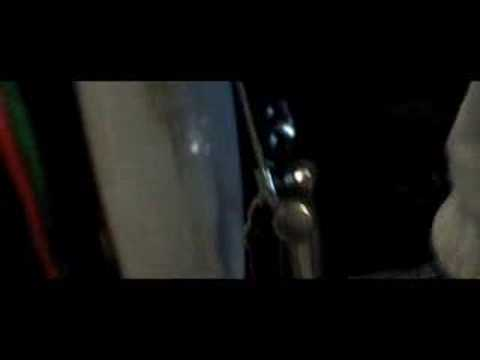

In [37]:
YouTubeVideo("CuEjiRyQhvc")

In [38]:
plt.style.use('ggplot')

In [ ]:
# # due to execution time, we're only going to read the first video

# feat_rgb = []
# feat_audio = []

# for example in tf.compat.v1.io.tf_record_iterator(frame_lvl_record):  #changed from tf.python_io.tf_record_iterator by Afia
#     tf_seq_example = tf.train.SequenceExample.FromString(example)
#     n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
#     sess = tf.InteractiveSession()
#     rgb_frame = []
#     audio_frame = []
#     # iterate through frames
#     for i in range(n_frames):
#         rgb_frame.append(tf.cast(tf.decode_raw(
#                 tf_seq_example.feature_lists.feature_list['rgb']
#                   .feature[i].bytes_list.value[0],tf.uint8)
#                        ,tf.float32).eval())
#         audio_frame.append(tf.cast(tf.decode_raw(
#                 tf_seq_example.feature_lists.feature_list['audio']
#                   .feature[i].bytes_list.value[0],tf.uint8)
#                        ,tf.float32).eval())


#     sess.close()

#     feat_audio.append(audio_frame)
#     feat_rgb.append(rgb_frame)
#     break

In [39]:
#This line of code is needed to disable the "eager execution". More details on stackoverflow
tf.compat.v1.disable_eager_execution()

In [40]:
# due to execution time, we're only going to read the first video

feat_rgb = []
feat_audio = []

for example in tf.compat.v1.io.tf_record_iterator(frame_lvl_record):  #changed from tf.python_io.tf_record_iterator by Afia
    tf_seq_example = tf.train.SequenceExample.FromString(example)
    n_frames = len(tf_seq_example.feature_lists.feature_list['audio'].feature)
    sess = tf.compat.v1.InteractiveSession()  #changed from tf.InteractiveSession()
    rgb_frame = []
    audio_frame = []
    # iterate through frames
    for i in range(n_frames):
        rgb_frame.append(tf.cast(tf.io.decode_raw( #changed from tf.decode_raw by Afia
                tf_seq_example.feature_lists.feature_list['rgb']
                  .feature[i].bytes_list.value[0],tf.uint8)
                      ,tf.float32).eval())
        audio_frame.append(tf.cast(tf.io.decode_raw(
                tf_seq_example.feature_lists.feature_list['audio']
                  .feature[i].bytes_list.value[0],tf.uint8)
                       ,tf.float32).eval())


    sess.close()

    feat_audio.append(audio_frame)
    feat_rgb.append(rgb_frame)
    break

In [41]:
print('The first video has %d frames' %len(feat_rgb[0]))

The first video has 234 frames


Vocabulary

In [ ]:
!pip install pandas

In [ ]:
import pandas as pd

In [ ]:
vocabulary = pd.read_csv('/content/vocabulary.csv')
vocabulary.head()